# Supply Chain

In [9]:

import pandas as pd
from pulp import * # pip install pulp
import matplotlib.pyplot as plt
from itertools import chain, repeat

def ncycles(iterable, n):
    "Returns the sequence elements n times"
    return chain.from_iterable(repeat(tuple(iterable), n))

# Item needs per Day After Time Series analysis
n_items = [31, 45, 40, 40, 48, 30, 25]
# Days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create repeating sliding list of days for scheduling bots
n_days = [i for i in range(7)]
n_days_c = list(ncycles(n_days, 3)) 
# Working days (included)
list_in = [[n_days_c[j] for j in range(i , i + 5)] for i in n_days_c]
# Bots in service for each day (if day = 0, bots starting on Tues and Wed are off) (excluded)
list_excl = [[n_days_c[j] for j in range(i + 1, i + 3)] for i in n_days_c]

# Model and Constraints

In [10]:
# Initialize Model using pulp
model = LpProblem("Bot Scheduling", LpMinimize)

# Create Variables
start_days = ['Shift: ' + i for i in days]
x = LpVariable.dicts('shift_', n_days, lowBound=0, cat='Integer')

# Define Objective (Sum of a list of linear terms)
model += lpSum([x[i] for i in n_days])

# Add constraints
for d, l_excl, item in zip(n_days, list_excl, n_items):
    model += lpSum([x[i] for i in n_days if i not in l_excl]) >= item

c:\Users\Field Employee\Desktop\DataScienceProcessAzure\supplychain\Lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


# Run model and analyze results

In [13]:
model.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[model.status])

# How many bots per day ?
dct_work = {}
for v in model.variables():
    dct_work[int(v.name[-1])] = int(v.varValue)
    
# Show Detailed Sizing per Day
dict_sch = {}
for day in dct_work.keys():
    dict_sch[day] = [dct_work[day] if i in list_in[day] else 0 for i in n_days]
df_sch = pd.DataFrame(dict_sch).T
df_sch.columns = days
df_sch.index = start_days

# The optimized objective function value is printed to the screen
print("Total number of Bots = ", pulp.value(model.objective))

Status: Optimal
Total number of Bots =  53.0


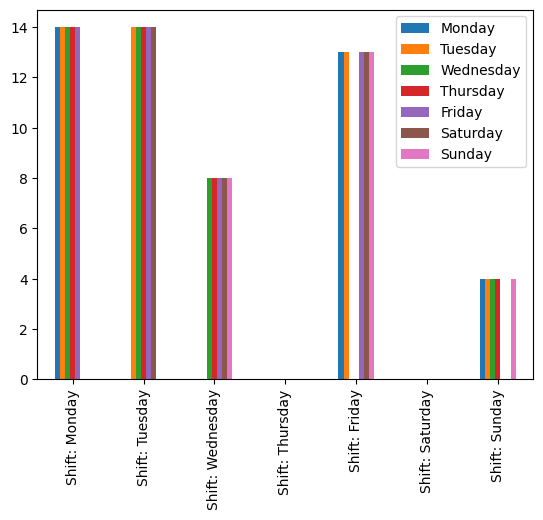

In [18]:
df_sch.plot(kind='bar')
plt.show()